In [114]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List, Callable
from scipy import stats
import Hawkes as hk
import timeit
import copy
import time
from tqdm import tqdm
import pandas as pd

In [115]:
register_matplotlib_converters()
sns.set()

# 1\ Simulation of homogeneous Poisson Processes and Hawkes processes.

In [49]:
def plot_poisson_process(T_i: List[float]) -> None:
    """Plots a poisson process given the event times.

    Parameters
    ----------
    T_i : List[float]
        List of event times as floats
    """
    eps = .1
    t = np.linspace(0, T_i[-1] + eps, num = int(T_i[-1] * 30))
    aux_fun = lambda s: np.sum([s > jump_time for jump_time in T_i])
    N_t = [aux_fun(t_k) for t_k in t]
    fig, ax = plt.subplots()
    ax.plot(t, 
             N_t)
    ax.set_title('Plot of the counting process N_t.')
    ax.set_ylabel('number of jumps')
    ax.set_xlabel('time')
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(True)
    ax.legend('Counting process')
    plt.show()

In [72]:
def plot_fn(x_i: List[float], y_i: List[List[float]], title: str, xlabel: str, ylabel: str, legend: List[str]) -> None:
    """Plots a function given the x,y points , title and labels.

    Parameters
    ----------
    x_i : List[float]
        X coordinates of points as a list of floats.
    y_i : List[List[float]]
        Y coordinates of points as a list of floats.
    title : str
        Title of the plots.
    xlabel : str
        Label of the x-axis.
    ylabel : str
        Label of the y-axis.
    """
    fig, ax = plt.subplots()
    for courbe in y_i:
        ax.plot(x_i, 
                courbe)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(True)
    ax.legend(legend)
    plt.show()

In [61]:
class HawkesProcess:
    """Class that encapsulates the simulation and parametrization of a Hawkes process.

    Attributes:
    -----------
        kernel : Callable
            A kernel function for the hawks process.
        baseline_intensity: float
            A baseline intensity for the hawks process.
        T : float
            End of the simulation interval.

    """
    def __init__(self, baseline_intensity, kernel, T):
        self.kernel = kernel
        self.baseline_intensity = baseline_intensity
        self.T = T
        self.lbd_star = baseline_intensity
    
    def rec_lbd(self, T_i : List[float], t : float):
        """Calculates the intensity of the hawkes process at a time t recursively.
        T_i is the list of jump times prior to t.

        Parameters
        ----------
        T_i : np.ndarray
            List of jump times of the process prior to t.
        t : float
            Current time for which to calculate intensity.

        Returns
        -------
        float
            Intensity of the process at time t.
        """
        if T_i.shape[0] == 0:
            # if there are no jumps prior to t
            return self.baseline_intensity


        else:
            # if there are jumps prior to t 
            # then calculate the kernel convolution with the last jump time and recurse)
            return np.sum(self.kernel(t-T_i) ) + self.baseline_intensity
    
    def simulate(self):
        """Simulate the process until time T

        Returns
        -------
        List[float]
            List of jump times before T.
        """
        # initialization
        self.x_ = [0.] # total abscisse
        self.y_ = [self.baseline_intensity] # stochastic lbd
        self.y_star_ = [self.baseline_intensity] # lbd_star

        # first date of event.
        t_0 = 0
        T_i = np.array([t_0])

        while t_0 <= self.T:
            # new candidate.
            s = stats.expon.rvs(scale = 1 / self.lbd_star)
            t_0 += s

            if t_0 > self.T:
                return T_i
            
            # thinning.
            d = stats.uniform.rvs()
            lbd_stoch = self.rec_lbd(T_i, t_0)

            if d <  lbd_stoch / self.lbd_star: # accept the event.

                x = list(np.linspace(t_0 - s, t_0, num = 30, endpoint = True))
                y = [self.rec_lbd(T_i, e) for e in x] if len(self.y_) > 1 else [self.lbd_star for _ in x]
                y_star = [self.lbd_star for _ in x]
                self.x_ = self.x_ + copy.deepcopy(x)
                self.y_ = self.y_ + copy.deepcopy(y)
                self.y_star_ = self.y_star_ + copy.deepcopy(y_star)

                # change the T_i, and as a consequence the lbd_fun
                T_i = np.append(T_i,t_0)
                self.lbd_star = self.rec_lbd(T_i, t_0)
                

            else: # no event. update lbd_star.
                x = list(np.linspace(t_0 - s, t_0, num = 30, endpoint = True))
                y = [self.rec_lbd(T_i, e) for e in x] if len(self.y_) > 1 else [self.lbd_star for _ in x]
                y_star = [self.lbd_star for _ in x]
                self.x_ = self.x_ + copy.deepcopy(x)
                self.y_ = self.y_ + copy.deepcopy(y)
                self.y_star_ = self.y_star_ + copy.deepcopy(y_star)
                
                self.lbd_star = lbd_stoch

        return T_i
            



# 2\ Sanity check 

For this Hawkes process to be sub-critical (stable), one needs alpha / beta < 1 if one chooses an exponential kernel of the form tau: alpha * exp(-beta * tau). Here the selected values are

````
alpha = .3
beta = .6
````

In [62]:
alpha = .3
beta = .6

In [63]:
hawkes_process = HawkesProcess(1., lambda tau: alpha * np.exp(-beta * tau), 20.)
process_realization = hawkes_process.simulate()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


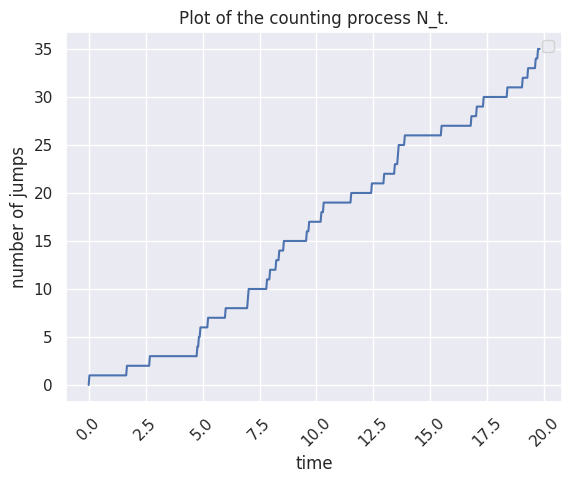

In [64]:
plot_poisson_process(process_realization)

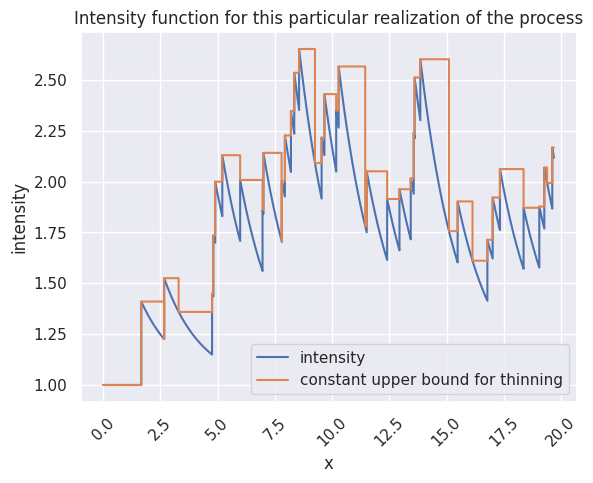

In [65]:
plot_fn(hawkes_process.x_, [hawkes_process.y_, hawkes_process.y_star_ ], 'Intensity function for this particular realization of the process', 'x', 'intensity', ['intensity', 'constant upper bound for thinning'])

# 3\ Convergance of MLE estimates

In [68]:
alpha = .6
beta = .8
T = np.linspace(start=50, stop = 500)

In [ ]:
processes = {T_mat : HawkesProcess(2., lambda tau: alpha * np.exp(-beta * tau), T_mat) for T_mat in T}
process_realisations = {}
for T_mat in T:
   process_realisations[T_mat]= processes[T_mat].simulate()

In [70]:
estimator = hk.estimator()
# set an exponential kernel
estimator.set_kernel('exp',num_exp=1)
# set a constant baseline function
estimator.set_baseline('const')

params_list = {T_mat : list(estimator.fit(process_realisations[T_mat],[0,T_mat]).parameter.values()) for T_mat in T}

We can very well see the convergeance of each parameter to its specified value in the following plots.

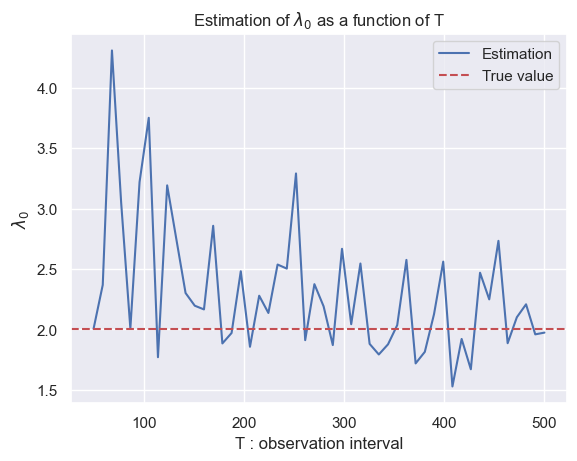

In [71]:
plt.plot(T, np.array([est[0] for est in params_list.values()]))
plt.title('Estimation of $\lambda_0$ as a function of T')
plt.xlabel('T : observation interval')
plt.ylabel('$\lambda_0$')
plt.axhline(y=2, color='r', linestyle='dashed')
plt.legend(['Estimation','True value'])
plt.show()

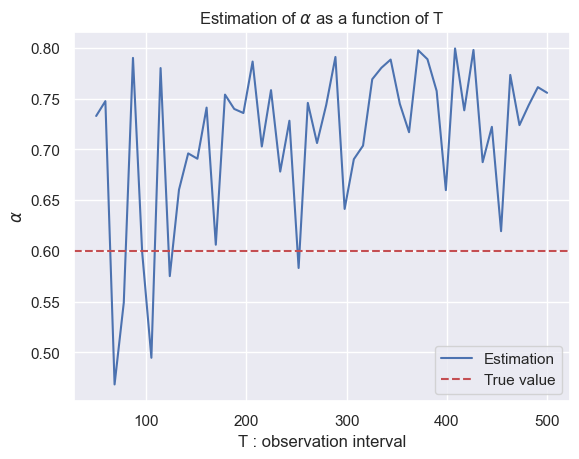

In [72]:
plt.plot(T, np.array([est[1] for est in params_list.values()]))
plt.title('Estimation of $\\alpha$ as a function of T')
plt.xlabel('T : observation interval')
plt.ylabel('$\\alpha$')
plt.axhline(y=alpha, color='r', linestyle='dashed')
plt.legend(['Estimation','True value'])
plt.show()

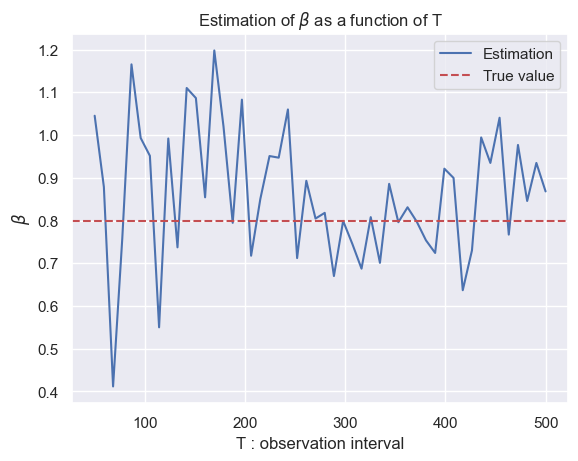

In [73]:
plt.plot(T, np.array([est[2] for est in params_list.values()]))
plt.title('Estimation of $\\beta$ as a function of T')
plt.xlabel('T : observation interval')
plt.ylabel('$\\beta$')
plt.axhline(y=beta, color='r', linestyle='dashed')
plt.legend(['Estimation','True value'])
plt.show()

The convergence of the parameters seems to happen quite fast, except for alpha. We can make it clearer with boxplots.

In [117]:
num_samples = 10

T = np.linspace(start=50, stop = 500, num = 4)
#T = [50, 55]
keys = ['lbd_0', 'alpha', 'beta']

# DATAFRAMES WITH TRIAL COLUMN ASSIGNED
dfs = []

for T_i in tqdm(T):

    df_dict = {key : [] for key in keys}

    for _ in range(num_samples):
        # simulate the process
        hawkes_process = HawkesProcess(2., lambda tau: alpha * np.exp(-beta * tau), T_i)
        process_realization = hawkes_process.simulate()

        # estimate the parameters
        estimator = hk.estimator()
        estimator.set_kernel('exp',num_exp=1)
        estimator.set_baseline('const')
        estimates = list(estimator.fit(process_realization,[0,T_i]).parameter.values())


        
        for i, key in enumerate(keys):
            df_dict[key].append(estimates[i])


    df_i = pd.DataFrame.from_dict(df_dict).assign(T=T_i)
    dfs.append(df_i)


100%|██████████| 4/4 [07:00<00:00, 105.04s/it]


In [118]:
cdf = pd.concat(dfs)      

In [119]:
mdf = pd.melt(cdf, id_vars=['T'], var_name=['parameter'])

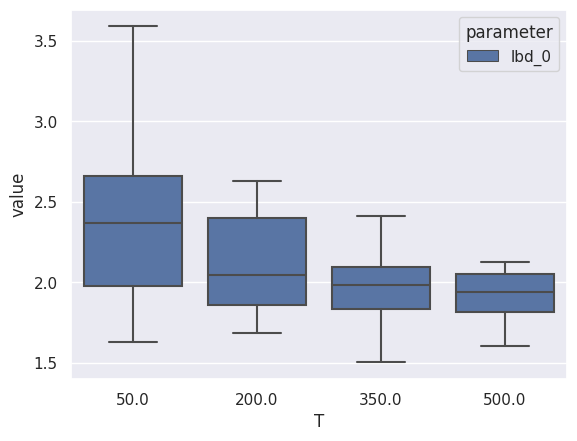

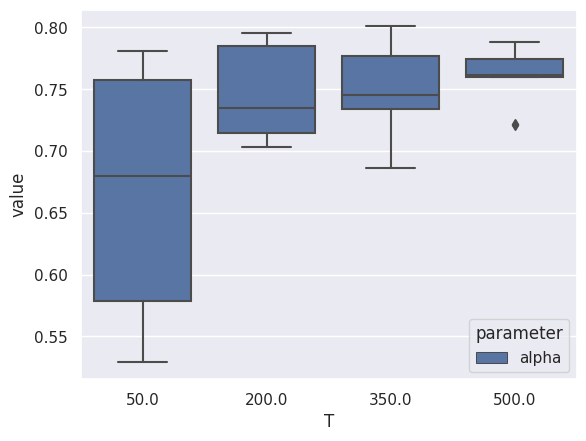

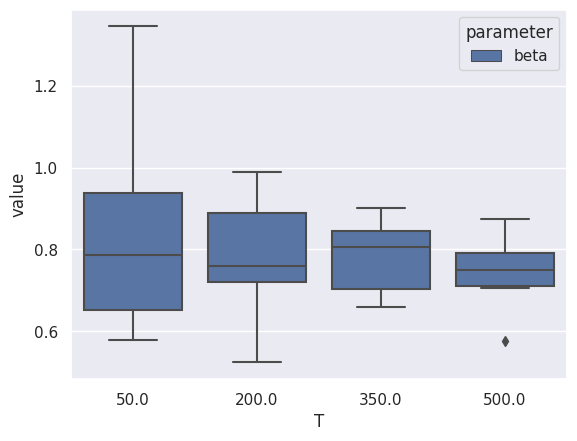

In [120]:
for key in keys:
    ax = sns.boxplot(x="T", y="value", hue="parameter", data=mdf[mdf['parameter'] == key])  
    plt.show()

    plt.clf()
    plt.close()

Or with all the parameters at once:

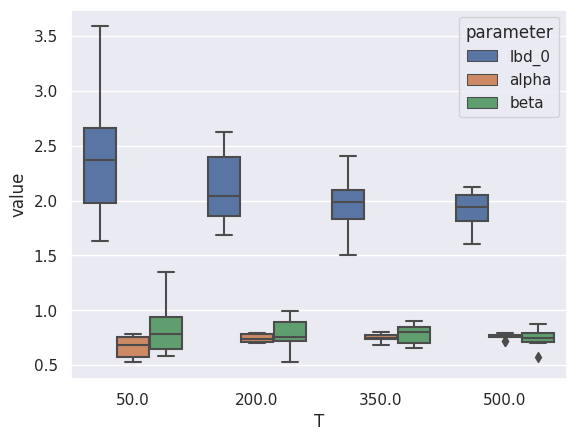

In [121]:
ax = sns.boxplot(x="T", y="value", hue="parameter", data=mdf)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

Again, the MLE estimates converges as T increases, even though it is less clear for alpha.

# 4\ Goodness of fit

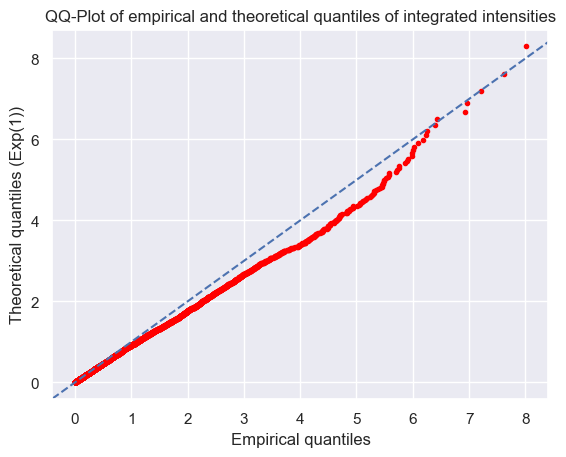

In [75]:
## we write a function that calculates the integral of hawks intensity between events times
def hawks_integral(baseline_intensity, horizon, sample, alpha, beta):
    
    integrated_intensities = [baseline_intensity * (sample[1] - sample[0]) + (alpha/beta)*(1 - np.exp(-beta*(sample[1] - sample[0]))) ]
    A = 1
    for i in range(2,len(sample)):
        
        
        integrated_intensities.append(
            baseline_intensity * (sample[i] - sample[i-1]) + (alpha/beta) * (1 - np.exp(-beta*(sample[i] - sample[i-1]))) *A
        )

        A = 1+ np.exp(-beta * (sample[i-1] - sample[i-2])) * A
    return(integrated_intensities)

hawkes_realisation= process_realisations[T[-1]]
params_estimation = params_list[T[-1]]
integrated_intensity = hawks_integral(params_estimation[0],T[-1],hawkes_realisation,params_estimation[1],params_estimation[2])
## now we sort the integrated intensities
integrated_intensity = np.sort(integrated_intensity)


empirical_quantiles = integrated_intensity
theoretical_quantiles = stats.expon.ppf( q = (np.arange(len(integrated_intensity)))/ len(integrated_intensity))

plt.plot(empirical_quantiles, theoretical_quantiles, '.', color = 'red')
plt.axline( (0,0),slope=1,linestyle='--')
plt.title('QQ-Plot of empirical and theoretical quantiles of integrated intensities')
plt.xlabel('Empirical quantiles')
plt.ylabel('Theoretical quantiles (Exp(1))')
plt.show()

We see that the integrated intensities do seem to follow an exponential law but the higher quantiles seem to be les concordant (probably because of the small sample size).

# 5\ Computational time

In [69]:
alpha = .6
beta = .8
T = np.linspace(start=50, stop = 500)
lambda_0 = 1.
hawkes_process = HawkesProcess(lambda_0, lambda tau: alpha * np.exp(-beta * tau), 20.)

def home_impl(T_mat):
    hawkes_process.T = T_mat
    hawkes_process.simulate()

model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'mu':lambda_0, 'alpha':alpha, 'beta':beta}
model.set_parameter(para)

def package_impl(T_mat):
    model.simulate([0,T_mat])

def time_functions(func1, func2, T):
    times1 = []
    times2 = []
    for t in T:
        start = time.time()
        func1(t)
        times1.append(time.time() - start)
        start = time.time()
        func2(t)
        times2.append(time.time() - start)
    return times1, times2


home_time, package_time = time_functions(home_impl, package_impl, T)

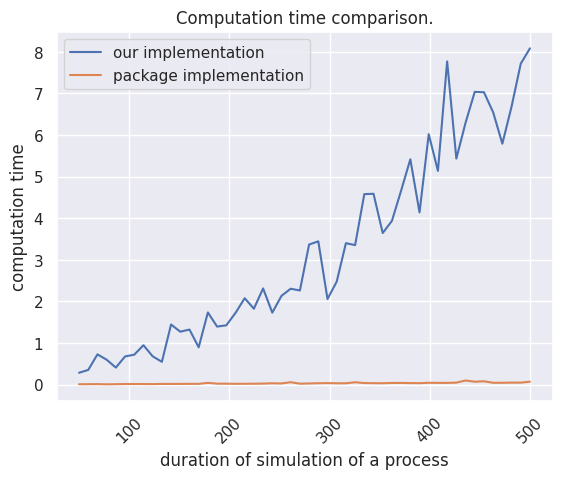

In [74]:
plot_fn(x_i = T, y_i = [home_time, package_time], title = 'Computation time comparison.', xlabel = 'duration of simulation of a process', ylabel = 'computation time', legend = ['our implementation', 'package implementation'])

It seems the cost of our implementation is exponential while the one in the package is much more efficient . This is probably due to the fact that we do not exploit enough the exponential kernel and  dynamic programming principle that can be applied in such a setup. Instead we use the generic algorithm that can be used for any kernel.